File exists
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14       

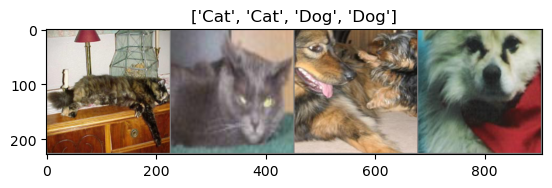

In [15]:
# Transfer Learning 
import torch
import torchvision
import torch.nn as nn 
import numpy as np
import torch.optim as optim
from torchvision import models
from torchvision import transforms
import copy
import os
from os import listdir
import shutil
from torchvision import datasets
import random
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights

# Create train and test dataset
data_dir = os.path.join('kagglecatsanddogs_3367a','PetImages')
os.makedirs(data_dir, exist_ok=True)

# Create the train and test set folder
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
train_dir_cat = os.path.join(train_dir,'Cat')
train_dir_dog = os.path.join(train_dir,'Dog')
validation_dir_cat = os.path.join(validation_dir,'Cat')
validation_dir_dog = os.path.join(validation_dir,'Dog')

try:
    os.mkdir(train_dir)
    os.mkdir(train_dir_dog)
    os.mkdir(train_dir_cat)
    os.mkdir(validation_dir)
    os.mkdir(validation_dir_dog)
    os.mkdir(validation_dir_cat)
except FileExistsError:
     print('File exists')

dir_cat = os.path.join(data_dir,'Cat') # Pls copy the corresponding folder(Cat) in the data set here in advance.
dir_dog = os.path.join(data_dir,'Dog') # Pls copy the corresponding folder(Dog) in the data set here in advance. 

files_cat = [os.path.join(dir_cat, f) for f in os.listdir(dir_cat) if os.path.isfile(os.path.join(dir_cat, f))]
files_dog = [os.path.join(dir_dog, f) for f in os.listdir(dir_dog) if os.path.isfile(os.path.join(dir_dog, f))]

rand_items_cats = random.sample(files_cat, int(len(files_cat)*0.8))
rand_items_dogs = random.sample(files_dog, int(len(files_dog)*0.8))

# validation_data
# train_data

def move_file_list(directory, file_list):
    """
    Move a list of files to a specified directory.  
    :param directory: The target directory path where files will be moved to.
    :param file_list: A list of full paths to the files to be moved.
    """
    for f in file_list:
        # Using os.path.basename to get the filename which is more explicit and cross-platform
        f_name = os.path.basename(f)
        # Constructing the new path ensuring it's compatible across different OS
        new_path = os.path.join(directory, f_name)
        shutil.move(f, new_path)
        
move_file_list(train_dir_dog, rand_items_dogs)
move_file_list(train_dir_cat, rand_items_cats)

files_cat_v = [os.path.join(dir_cat, f) for f in os.listdir(dir_cat) if os.path.isfile(os.path.join(dir_cat, f))]
files_dog_v = [os.path.join(dir_dog, f) for f in os.listdir(dir_dog) if os.path.isfile(os.path.join(dir_dog, f))]

move_file_list(validation_dir_cat, files_cat_v)
move_file_list(validation_dir_dog, files_dog_v)

# Load Data
# Data augmentation and normalization for training
# Just normalization for validation
mean = np.array([ 0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cpu")

def imshow(input_image, title=None):
    """Plot the input tensor as animage"""
    input_image = input_image.numpy()
    input_image = input_image.transpose((1, 2, 0))
    input_image = std * input_image + mean
    plt.imshow(input_image)
    plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
plt.savefig('output_image.png')

def train_model(model, criterion, optimizer, scheduler, epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)               
                  
                # zero the parameter gradients
                optimizer.zero_grad()
                    
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # After the optimizer.step(), call the scheduler.step()
                scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Training finish')
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# To run this cell it's necessary to install torchsummary
from torchsummary import summary
summary(model_ft, input_size=(3,256,256))

#Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and testing
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       epochs=10)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#And now we can finally train it:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       epochs=10)